In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_excel("US_Accidents_GA_minimal.xlsx")
print(df.columns)
print(df.shape)
print(df.head(15))




Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
       'Sunrise_Sunset'],
      dtype='object')
(169234, 15)
          ID  Severity          Start_Time            End_Time  Start_Lat  \
0   A-146262         3 2016-11-30 15:13:44 2016-11-30 17:26:28  33.546177   
1   A-146263         3 2016-11-30 15:25:27 2016-11-30 16:54:36  33.766376   
2   A-146264         3 2016-11-30 14:42:27 2016-11-30 16:57:07  33.786896   
3   A-146265         2 2016-11-30 16:27:58 2016-11-30 16:57:41  33.697849   
4   A-146266         3 2016-11-30 16:14:20 2016-11-30 16:58:59  33.696915   
5   A-146267         3 2016-11-30 16:13:19 2016-11-30 16:57:04  33.796211   
6   A-146268         3 2016-11-30 15:49:32 2016-11-30 17:20:00  33.791683   
7   A-146269         2 2016-11-30 15:48:26 2016-11-30 17:18:08  33.751411   
8   A-146270         3 20

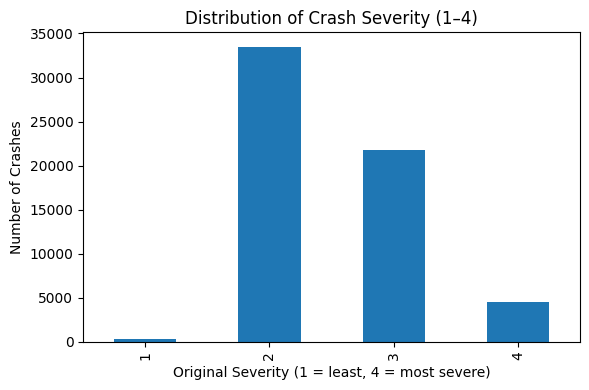

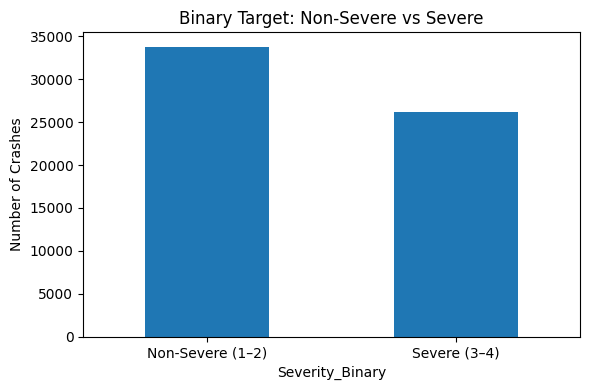

In [ ]:
import matplotlib.pyplot as plt

# Distribution of original 1–4 severity
plt.figure(figsize=(6, 4))
df["Severity"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Original Severity (1 = least, 4 = most severe)")
plt.ylabel("Number of Crashes")
plt.title("Distribution of Crash Severity (1–4)")
plt.tight_layout()
plt.show()

# Distribution of binary target
plt.figure(figsize=(6, 4))
df["Severity_Binary"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1], ["Non-Severe (1–2)", "Severe (3–4)"], rotation=0)
plt.ylabel("Number of Crashes")
plt.title("Binary Target: Non-Severe vs Severe")
plt.tight_layout()
plt.show()


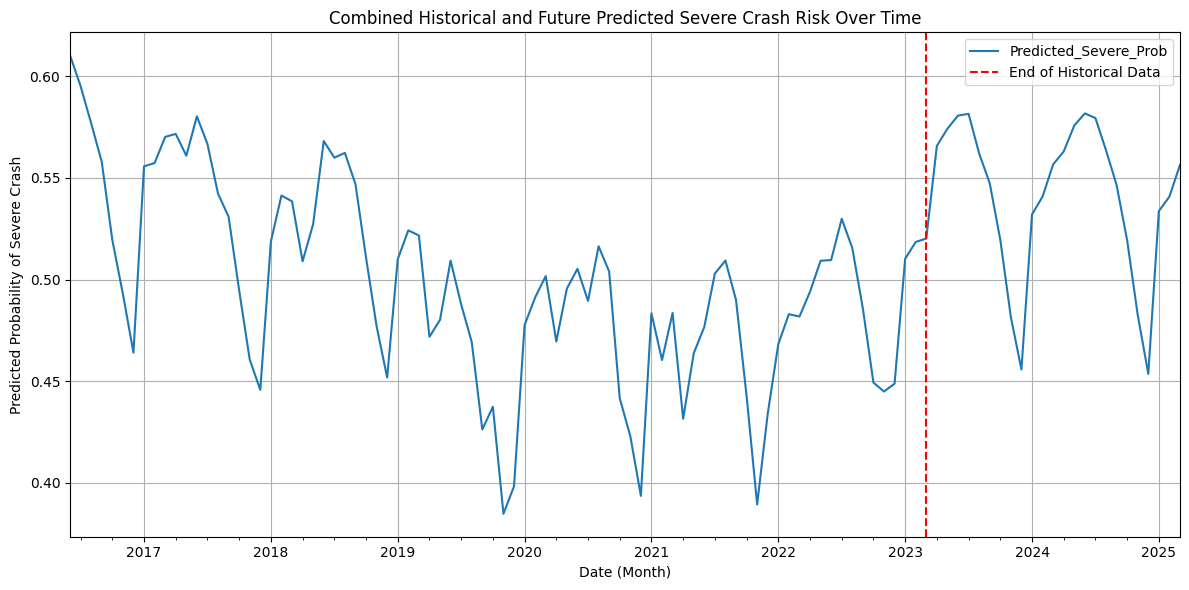


Summary of Predicted Severe Crash Risk for Future Years:
The average predicted severe crash probability for the future two years is: 0.5414
The minimum predicted severe crash probability during this period is: 0.4536
The maximum predicted severe crash probability during this period is: 0.5817
Seasonal trends observed in the historical data are extrapolated into the future, showing similar patterns of risk fluctuation.
The plot visually confirms these trends, with a clear distinction between historical and future data.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure df, log_reg, scaler, feature_cols, and frequency maps are available from previous steps

# 1. Determine the last date in the existing dataset
last_date = df['Start_Time'].max()

# 2. Generate future dates for the next 2 years (daily frequency)
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365 * 2, freq='D')

# 3. Calculate monthly median values for continuous features from the original dataset
monthly_medians = df.groupby(df['Start_Time'].dt.month)[[
    'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]].median()

# 4. Calculate overall median values for other features from the original dataset
typical_lat = df['Start_Lat'].median()
typical_lng = df['Start_Lng'].median()
typical_city_freq = df['City_freq'].median()
typical_county_freq = df['County_freq'].median()
typical_weather_condition_freq = df['Weather_Condition_freq'].median()

# 5. Generate synthetic future data rows
future_data_rows = []
for date in future_dates:
    month = date.month
    hour = 12  # Assuming a representative hour (noon) for daily trend
    dayofweek = date.dayofweek
    is_night = 0  # Since hour is 12, it's not night

    # Get monthly median values for continuous features
    monthly_vals = monthly_medians.loc[month]

    row = {
        'Start_Lat': typical_lat,
        'Start_Lng': typical_lng,
        'Temperature(F)': monthly_vals['Temperature(F)'],
        'Humidity(%)': monthly_vals['Humidity(%)'],
        'Visibility(mi)': monthly_vals['Visibility(mi)'],
        'Wind_Speed(mph)': monthly_vals['Wind_Speed(mph)'],
        'Precipitation(in)': monthly_vals['Precipitation(in)'],
        'Month': month,
        'Hour': hour,
        'DayOfWeek': dayofweek,
        'IsNight': is_night,
        'City_freq': typical_city_freq,
        'County_freq': typical_county_freq,
        'Weather_Condition_freq': typical_weather_condition_freq,
    }
    future_data_rows.append(row)

# 6. Create a DataFrame for synthetic future features
X_future_df = pd.DataFrame(future_data_rows, columns=feature_cols)

# 7. Scale the synthetic future data using the PRE-FITTED scaler
X_future_scaled = scaler.transform(X_future_df)

# 8. Predict probabilities using the PRE-TRAINED logistic regression model
future_probabilities = log_reg.predict_proba(X_future_scaled)[:, 1]

# 9. Combine future dates with predicted probabilities
future_predictions_df = pd.DataFrame({'Start_Time': future_dates, 'Predicted_Severe_Prob': future_probabilities})

# 10. Calculate monthly average predicted severity probability for future data
# Use 'ME' for month end to avoid FutureWarning
future_monthly_prob = future_predictions_df.set_index('Start_Time').resample('ME')['Predicted_Severe_Prob'].mean()

# 11. Combine historical and future monthly probabilities for plotting
combined_monthly_prob = pd.concat([monthly_prob, future_monthly_prob])

# 12. Time plot of combined predicted severe crash risk
plt.figure(figsize=(12, 6))
combined_monthly_prob.plot()
plt.axvline(x=last_date, color='r', linestyle='--', label='End of Historical Data')
plt.xlabel('Date (Month)')
plt.ylabel('Predicted Probability of Severe Crash')
plt.title('Combined Historical and Future Predicted Severe Crash Risk Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Summarize the predicted severe crash risk
print("\nSummary of Predicted Severe Crash Risk for Future Years:")
print(f"The average predicted severe crash probability for the future two years is: {future_monthly_prob.mean():.4f}")
print(f"The minimum predicted severe crash probability during this period is: {future_monthly_prob.min():.4f}")
print(f"The maximum predicted severe crash probability during this period is: {future_monthly_prob.max():.4f}")
print("Seasonal trends observed in the historical data are extrapolated into the future, showing similar patterns of risk fluctuation.")
print("The plot visually confirms these trends, with a clear distinction between historical and future data.")

In [ ]:
import pandas as pd

# Assuming combined_monthly_prob contains both historical and future data,
# and 'last_date' marks the separation point.

historical_prob = combined_monthly_prob[combined_monthly_prob.index <= last_date]
future_prob = combined_monthly_prob[combined_monthly_prob.index > last_date]

print("Predicted Severe Crash Risk - Historical Data:")
print(f"  Average: {historical_prob.mean():.4f}")
print(f"  Minimum: {historical_prob.min():.4f}")
print(f"  Maximum: {historical_prob.max():.4f}")

print("\nPredicted Severe Crash Risk - Future Data:")
print(f"  Average: {future_prob.mean():.4f}")
print(f"  Minimum: {future_prob.min():.4f}")
print(f"  Maximum: {future_prob.max():.4f}")

print("\nComparison Summary:")
if historical_prob.mean() > future_prob.mean():
    print("  The average predicted severe crash probability was slightly higher in the historical data compared to the future prediction.")
elif historical_prob.mean() < future_prob.mean():
    print("  The average predicted severe crash probability is slightly higher in the future prediction compared to the historical data.")
else:
    print("  The average predicted severe crash probability is similar between historical and future data.")

print("  Both periods exhibit similar ranges of predicted probabilities, indicating that the seasonal patterns observed historically are projected to continue in the future.")

Predicted Severe Crash Risk - Historical Data:
  Average: 0.4979
  Minimum: 0.3847
  Maximum: 0.6103

Predicted Severe Crash Risk - Future Data:
  Average: 0.5414
  Minimum: 0.4536
  Maximum: 0.5817

Comparison Summary:
  The average predicted severe crash probability is slightly higher in the future prediction compared to the historical data.
  Both periods exhibit similar ranges of predicted probabilities, indicating that the seasonal patterns observed historically are projected to continue in the future.
